# Churn detection 

The purpose of the project is to build the best performing classification model for churn problem in bank sector. Project is based on "Churn Modelling" [dataset](https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling) from Kaggle website. 

> Features description:
<br> Credit score - client credit score
<br> Geography - the country form which the customer belongs
<br> Gender - Male or Female 
<br> Age - Age of the customer
<br> Tenure - Number of years the customer has been with the bank
<br> Balance - Customer's bank account balance 
<br> NumOfProducts - Number of products the customer is using

Study contains section like *data understanding*, *data preparation*, *modeling*, *model evaluation*.

### Libraries imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot as skplt
import seaborn as sns
import sweetviz as sv
import warnings

from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from xgboost import XGBClassifier

%matplotlib inline
warnings.filterwarnings('ignore')
rndm = 101

C:\Users\brtkr\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Data load

In [2]:
churn = pd.read_csv('../Data/Churn_Modelling.csv')
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


These columns can be droped at the beginning, because they do not contribute any information.

In [3]:
churn.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

## Data understanding

### Exploration

In [4]:
churn.shape

(10000, 11)

In [5]:
churn.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


There are 5 ratio scale variables, one interval and five nominal. 

In [6]:
churn.describe(include=object).T

,count,unique,top,freq
Geography,10000,3,France,5014
Gender,10000,2,Male,5457


In [7]:
churn.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 1.9 MB


In [8]:
churn.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Dataset has no NaN values.

### Visualisation

                                             |                                             | [  0%]   00:00 ->…


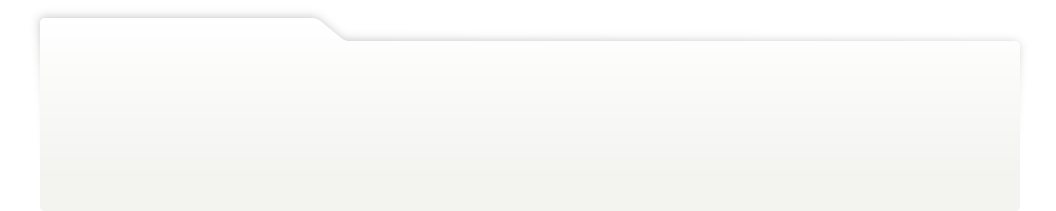
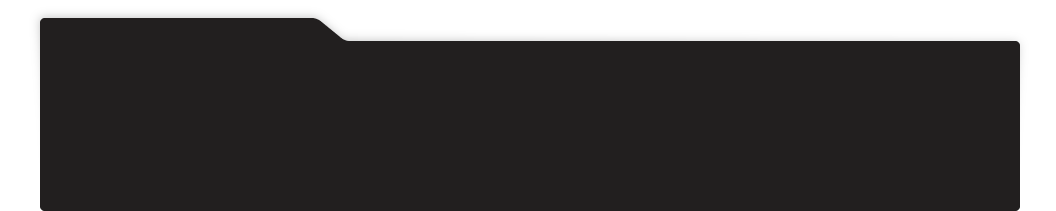
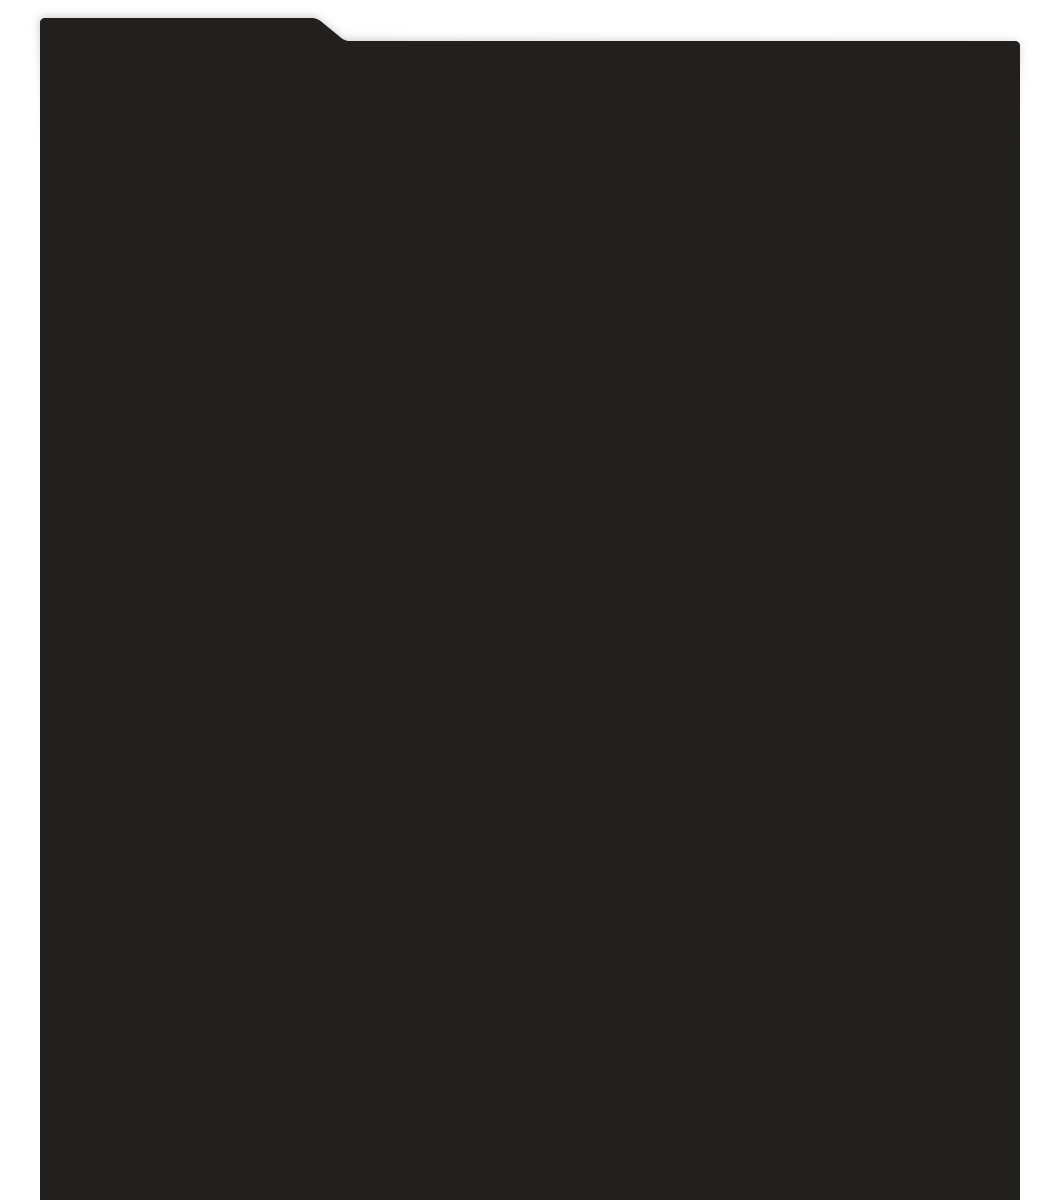
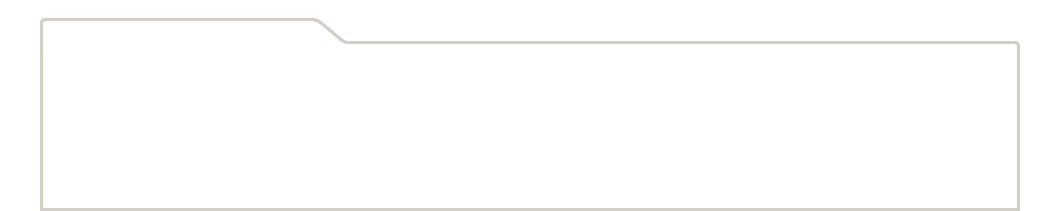
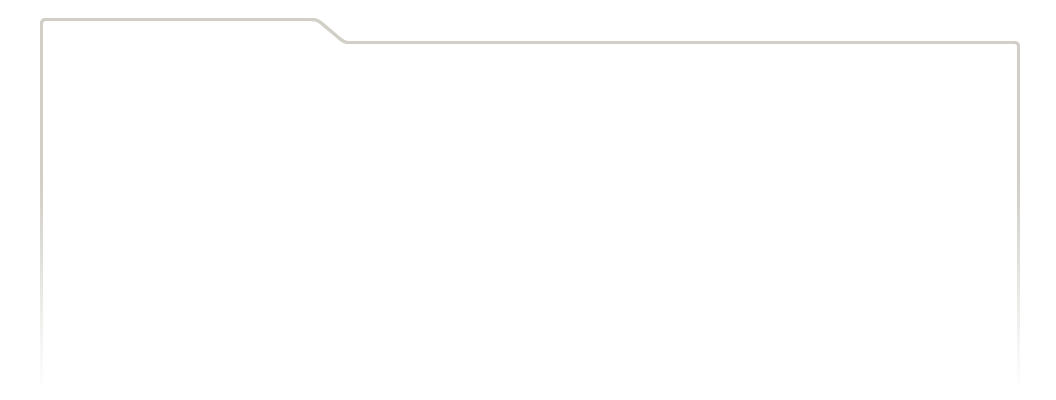
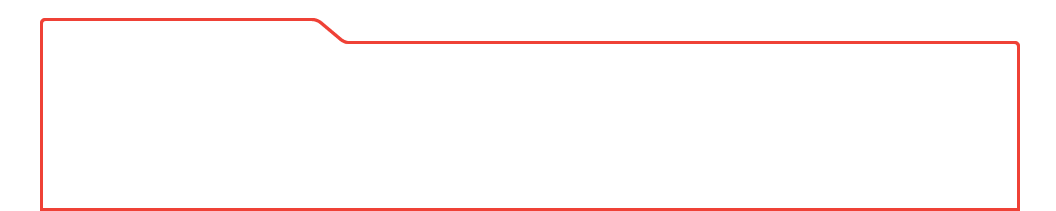
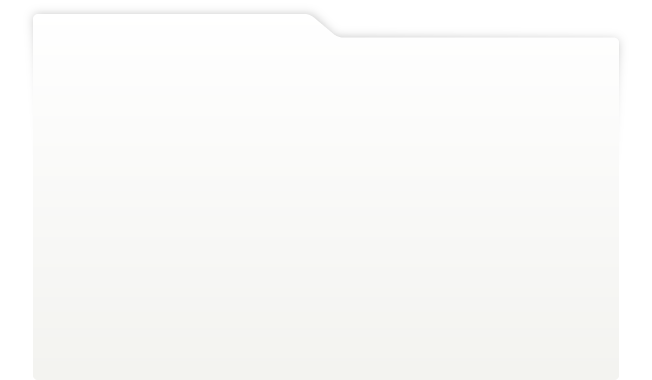
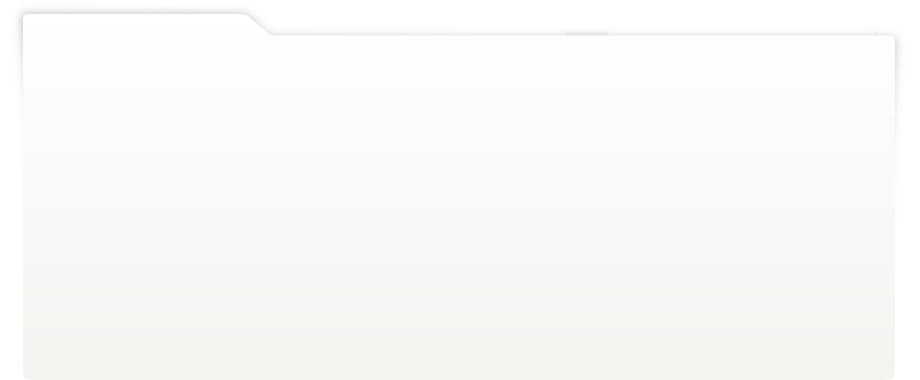
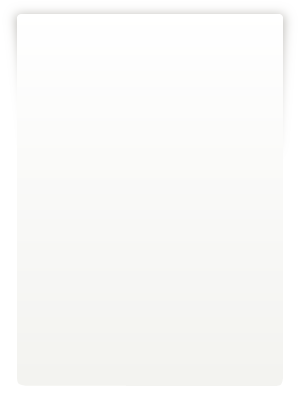
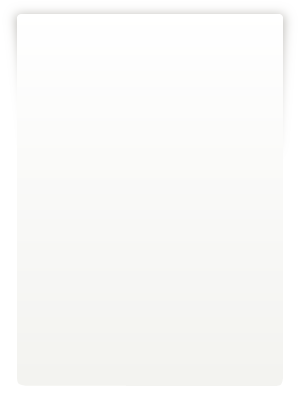
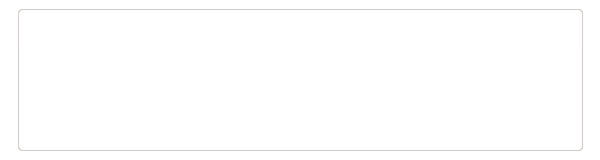
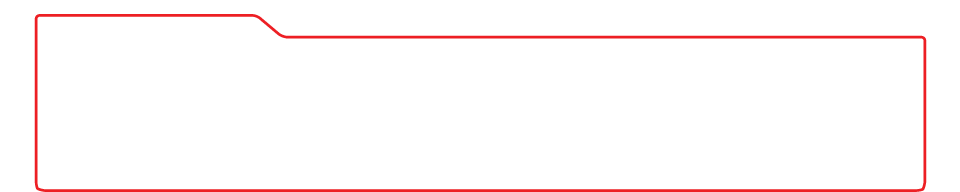
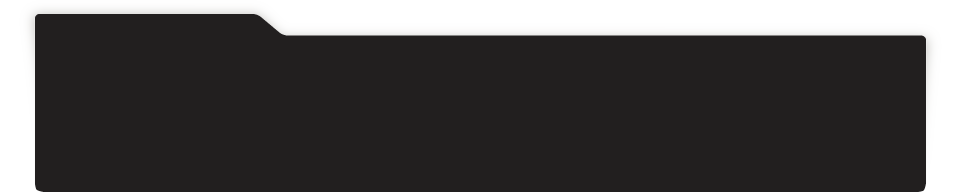
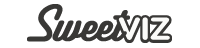
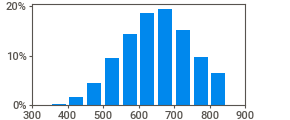
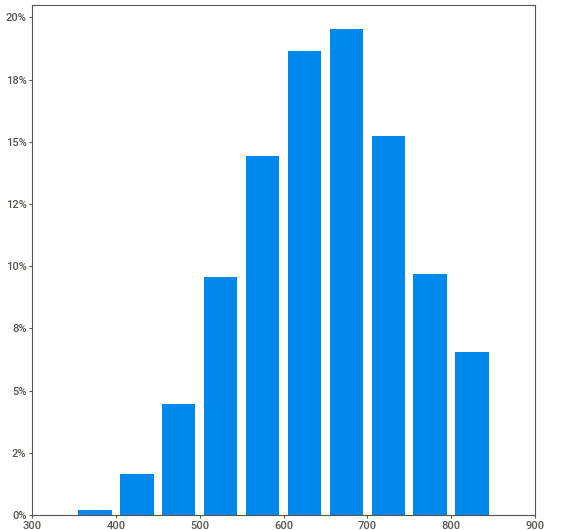
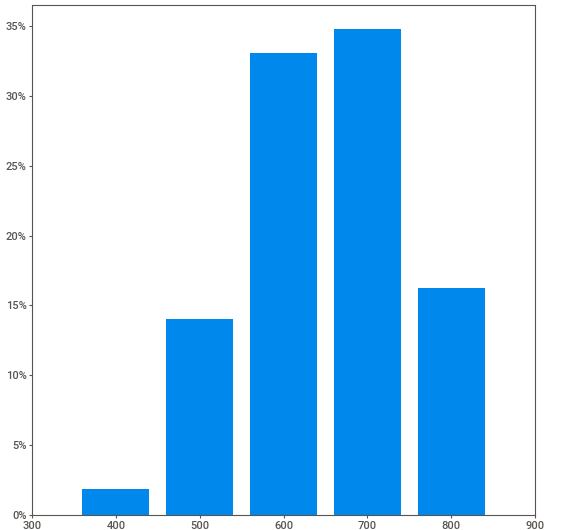
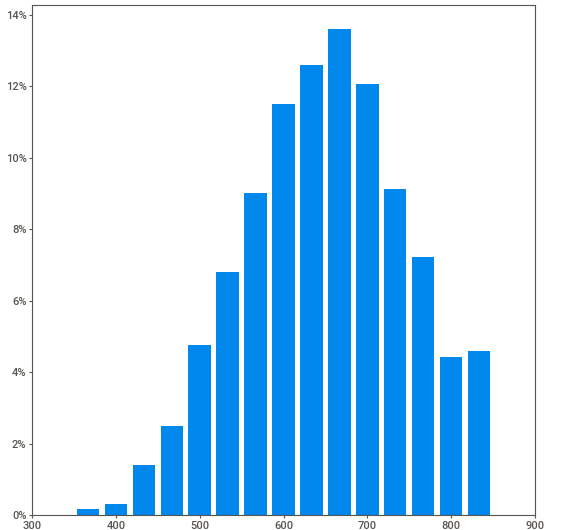
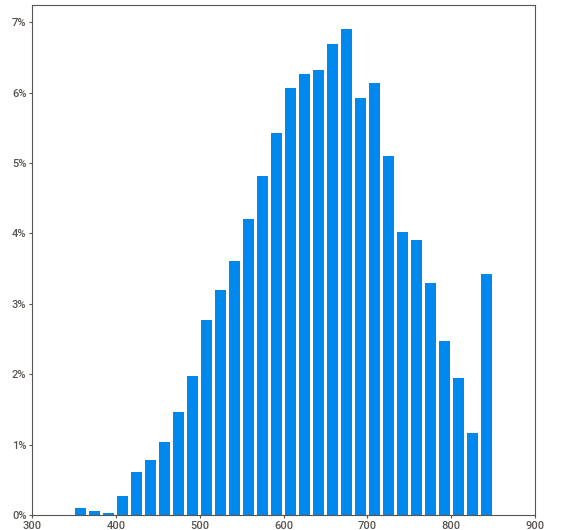
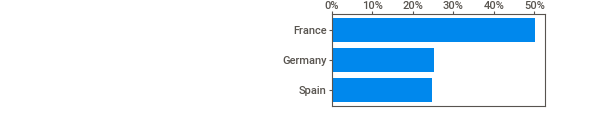
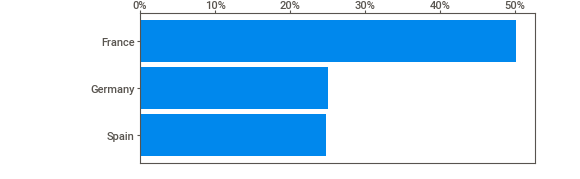
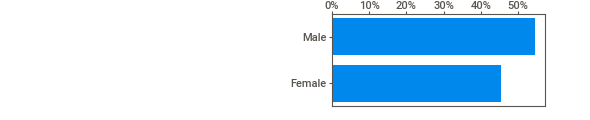
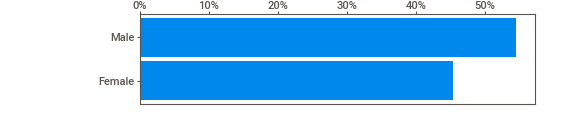
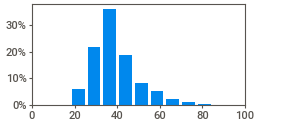
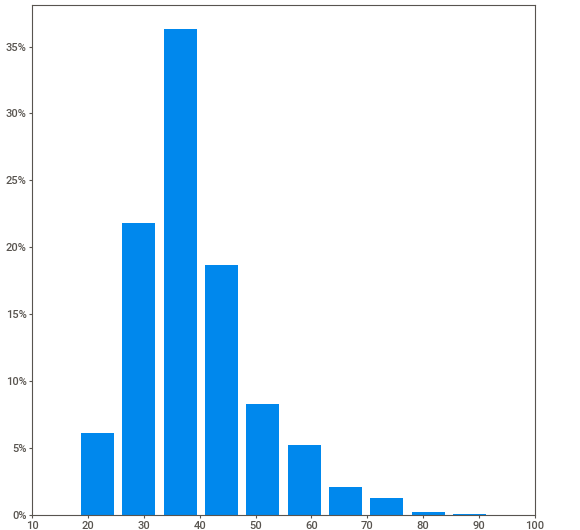
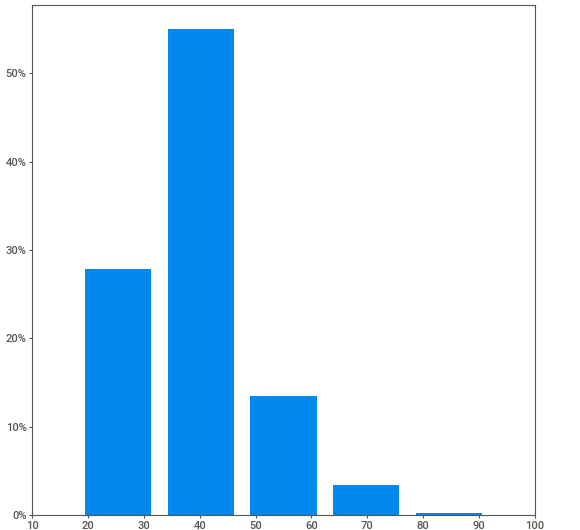
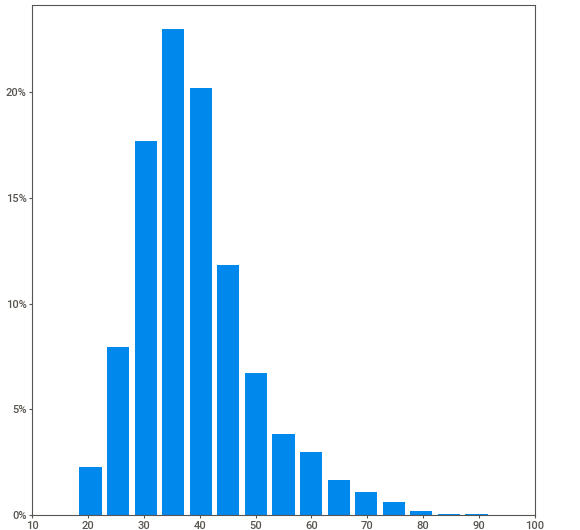
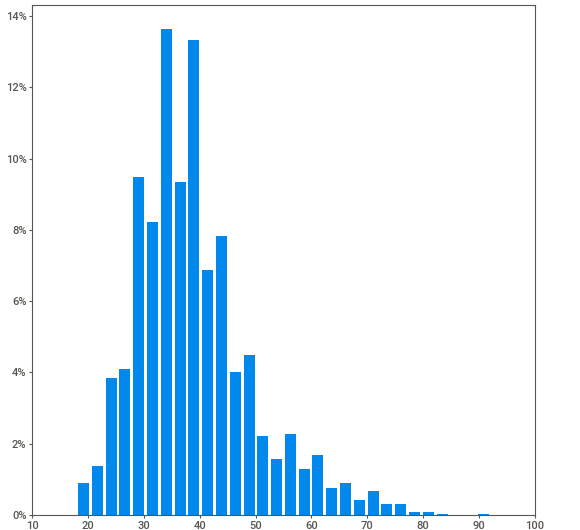
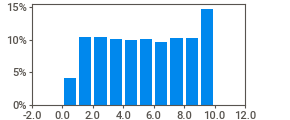
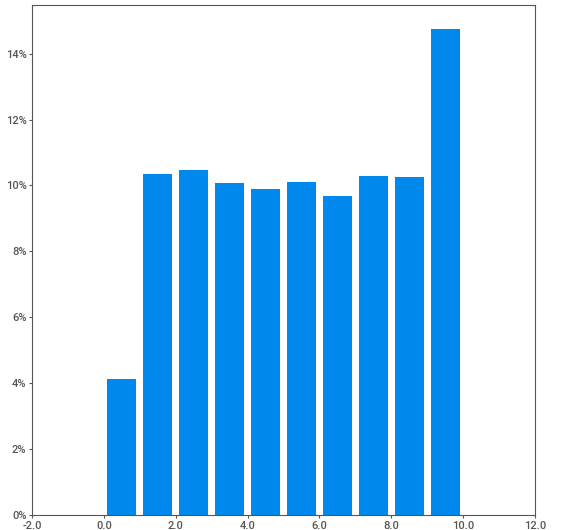
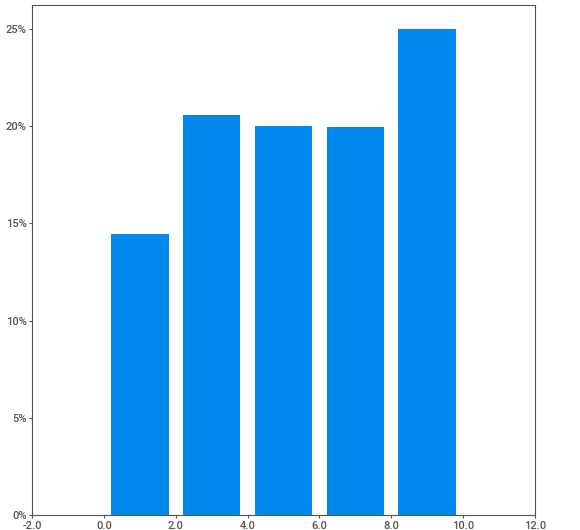
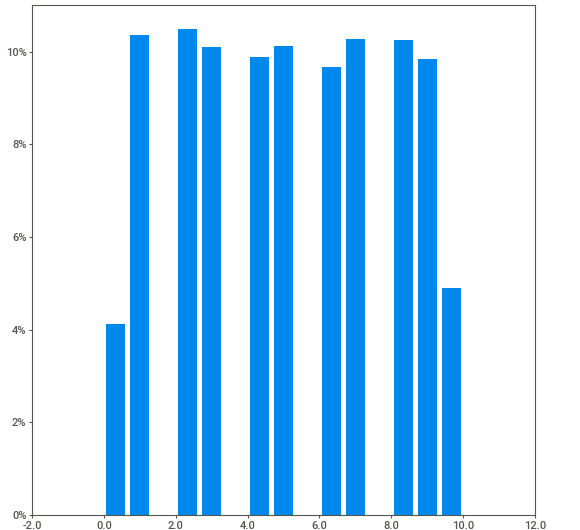
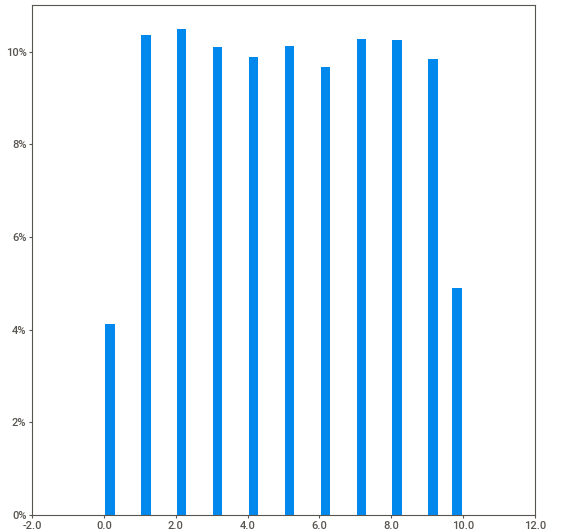
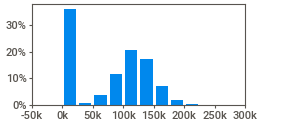
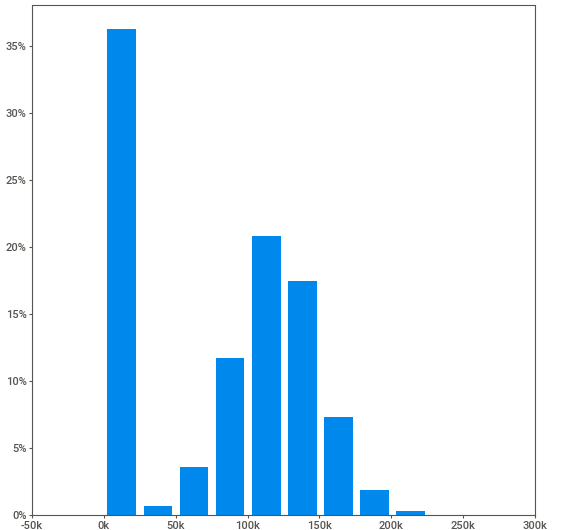
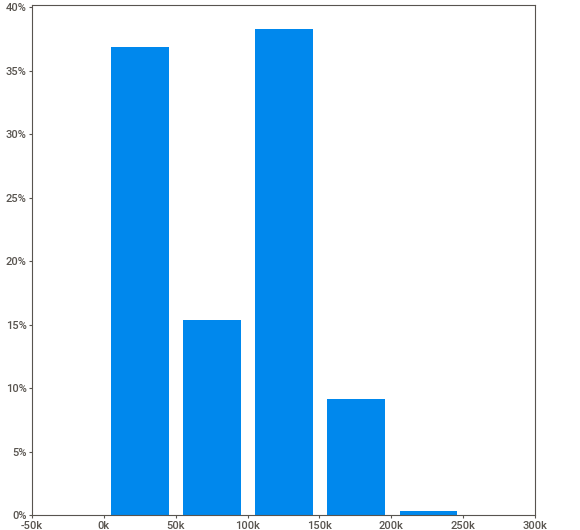
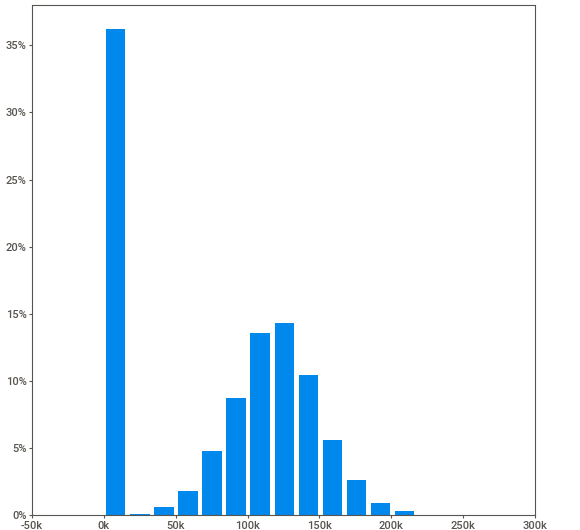
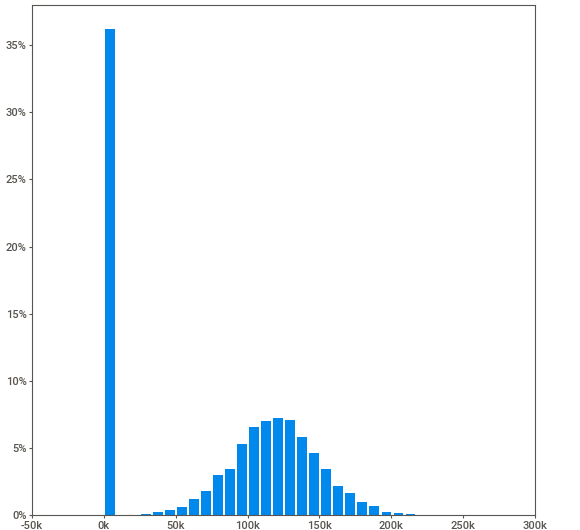
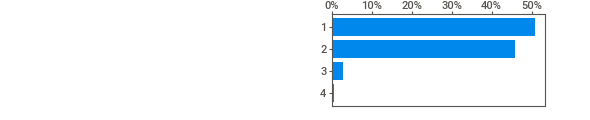
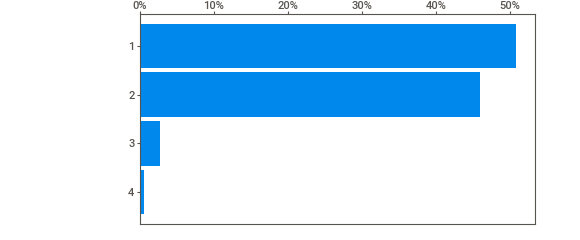
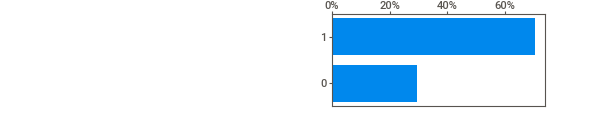
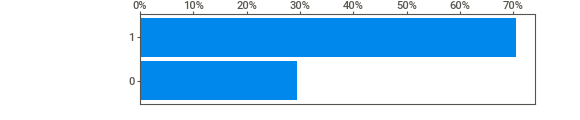
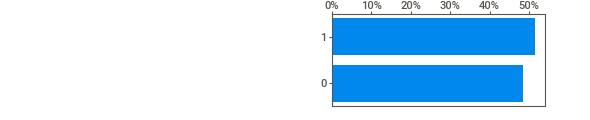
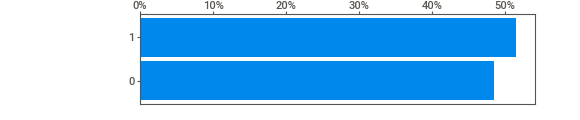
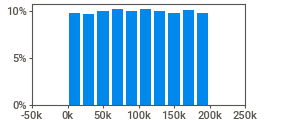
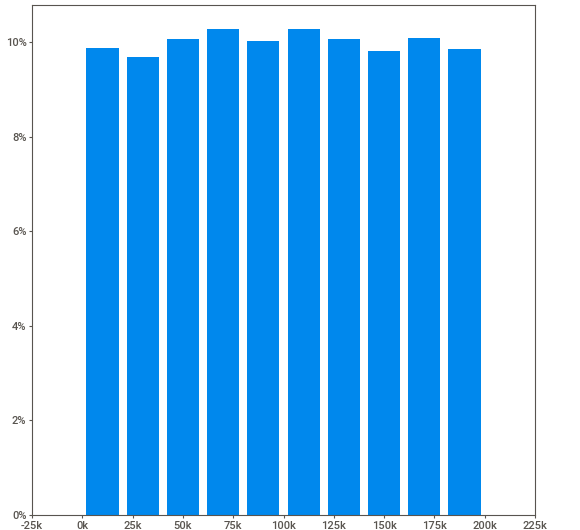
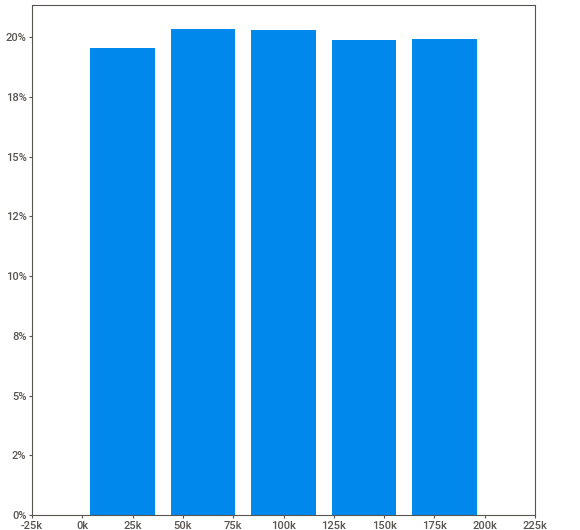
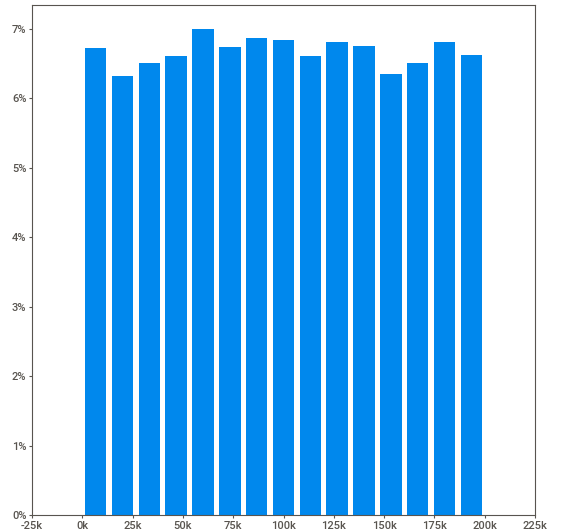
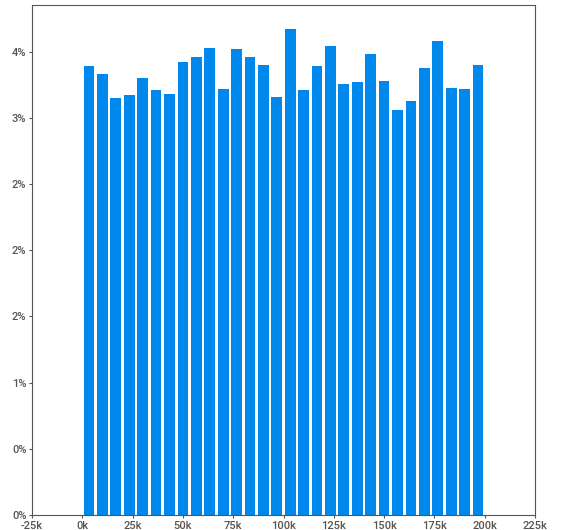
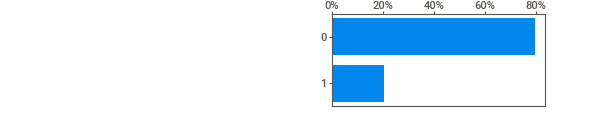
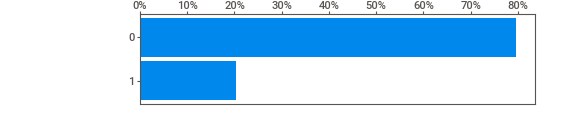
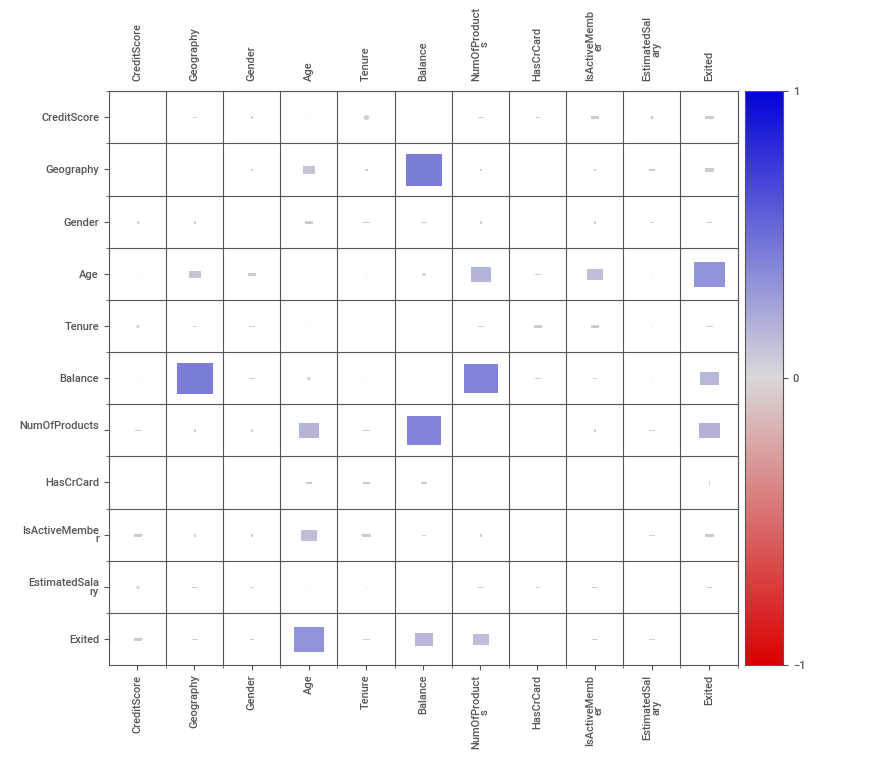
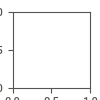

In [9]:
report = sv.analyze(churn)
report.show_notebook()

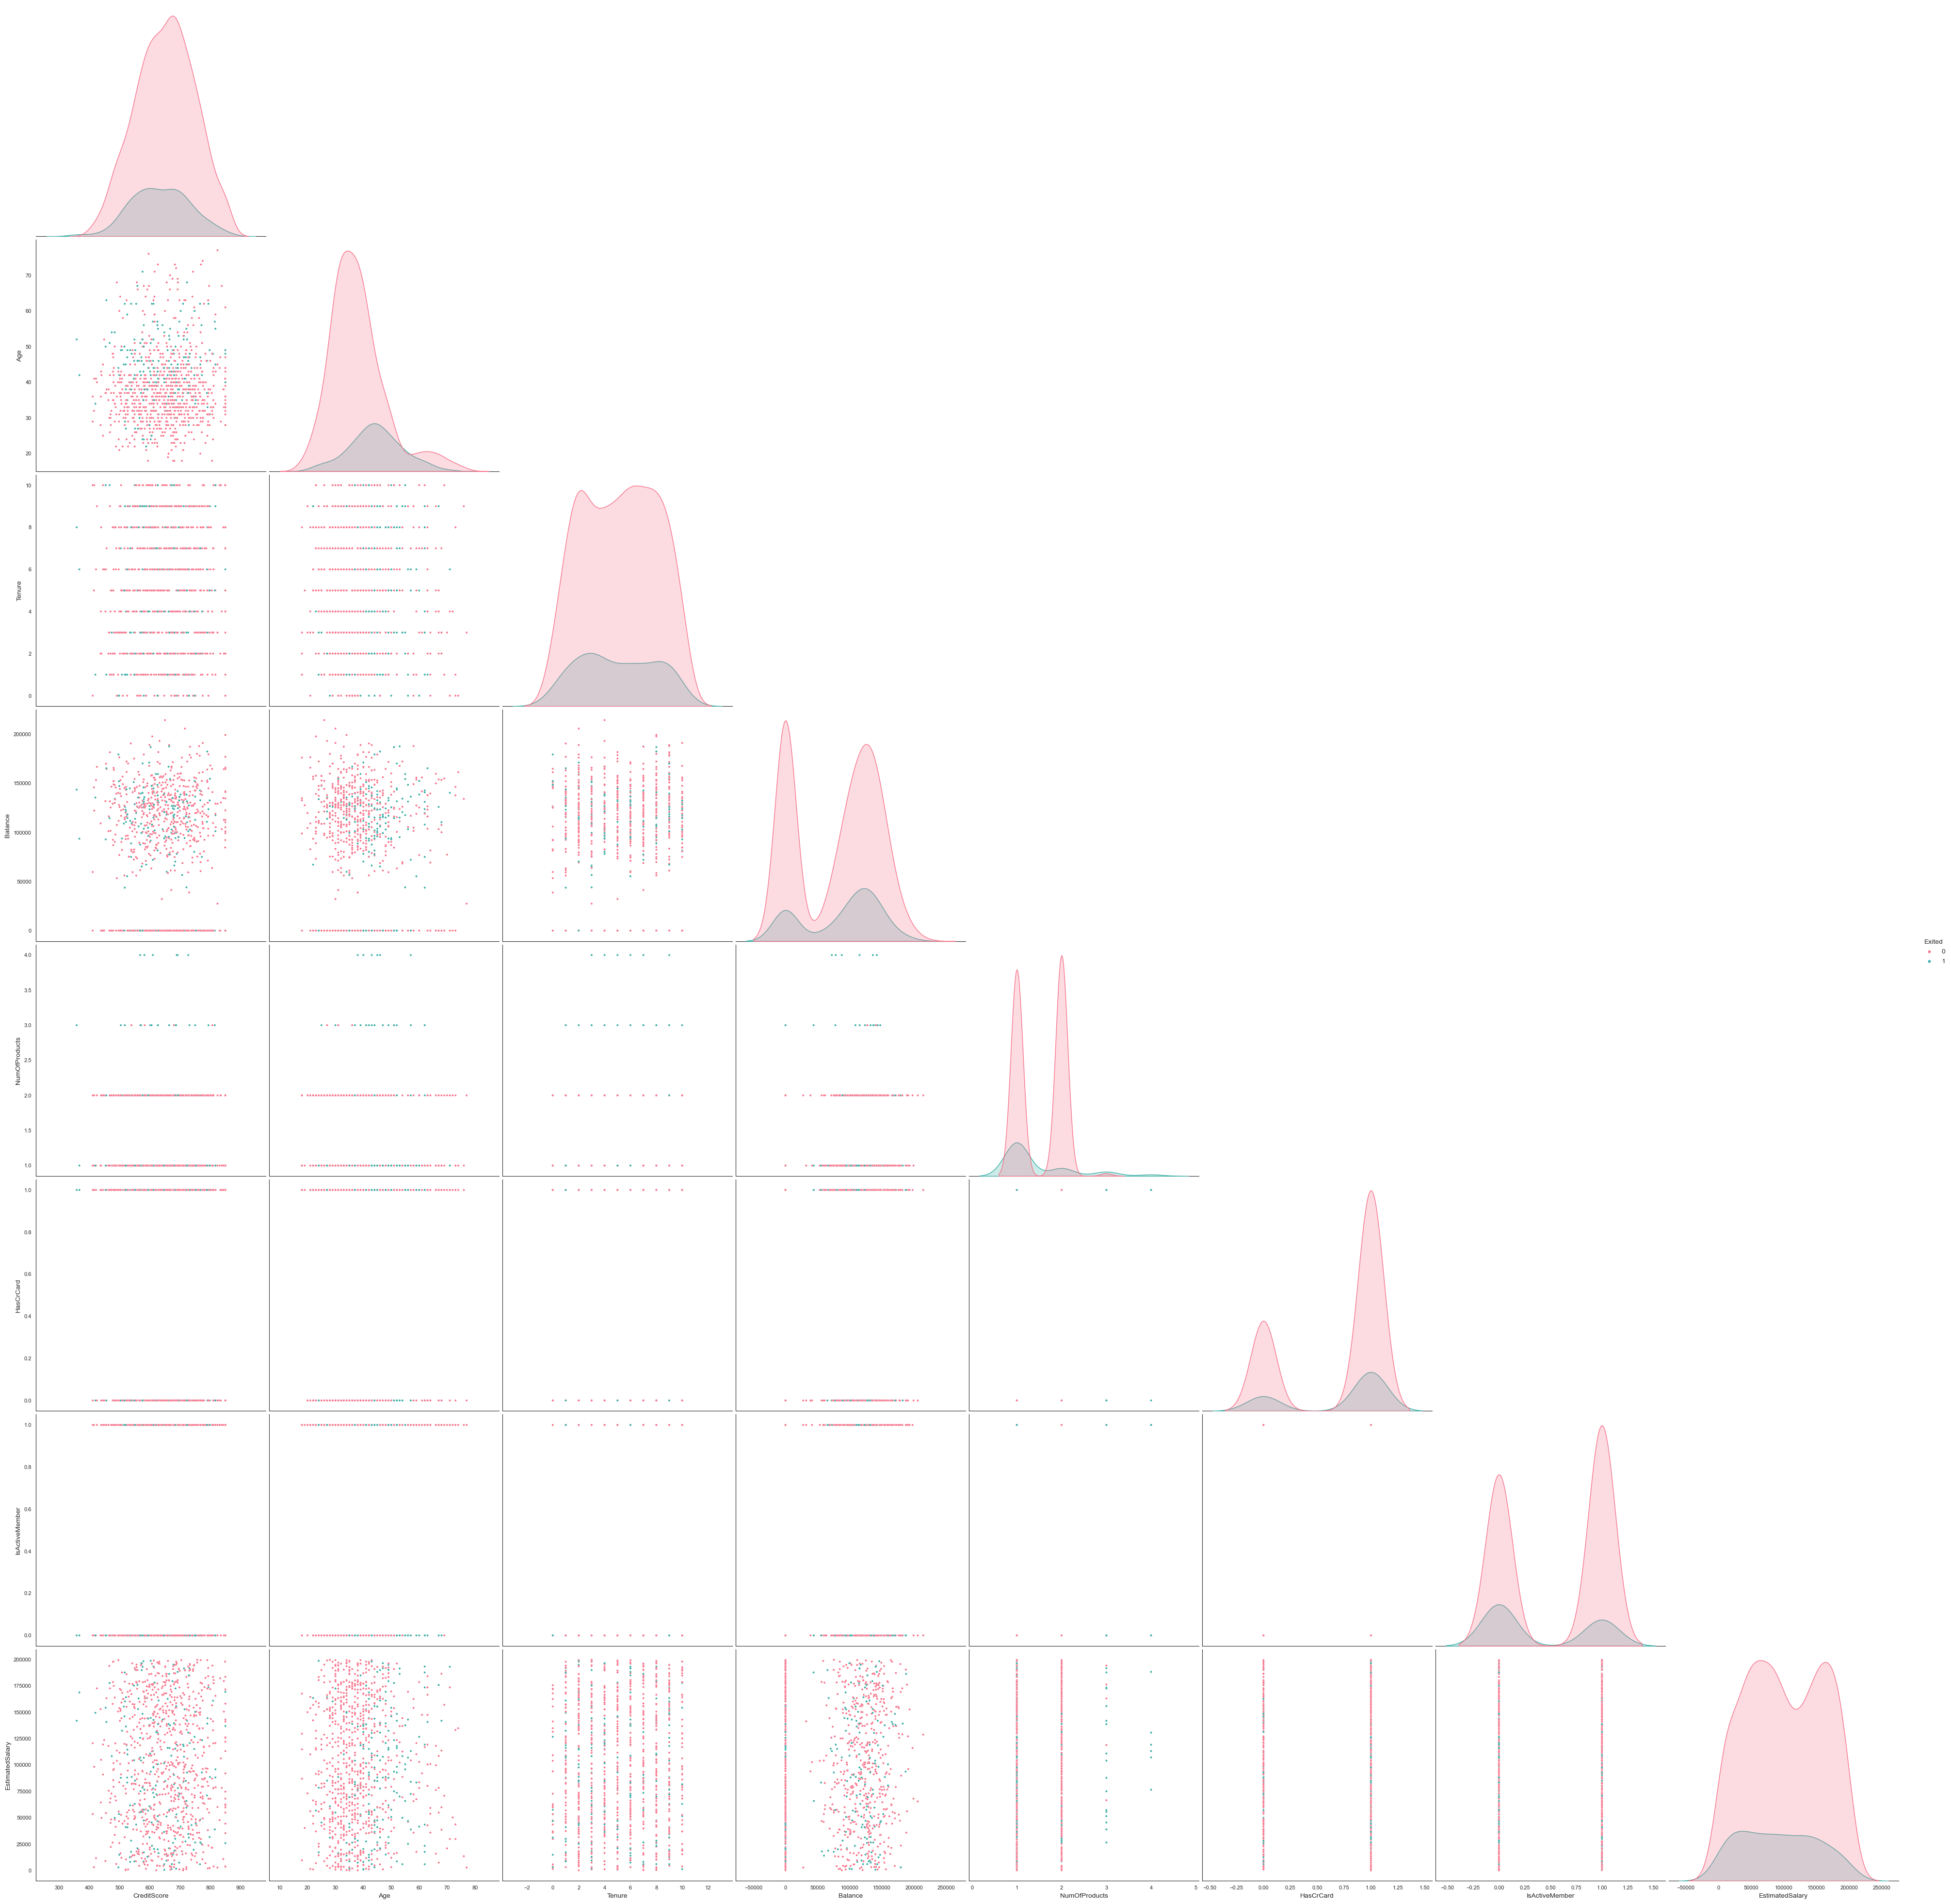

In [10]:
sns.set_style('white')
sns.pairplot(churn.sample(1000), hue='Exited', corner=True, palette=sns.husl_palette(n_colors=2), height=5)

In pairplot figure can be seen that people are more eager to close bank account right after their forties (different median values among classes). In case NumOfProducts feature, despite of the largest number of customers with two products, these with one close account more often. In additon clients with 3 or 4 products in most cases are quitters. Another noticeable occurance is much higher quitters/remainers ratio in not active member group than one with active customers.

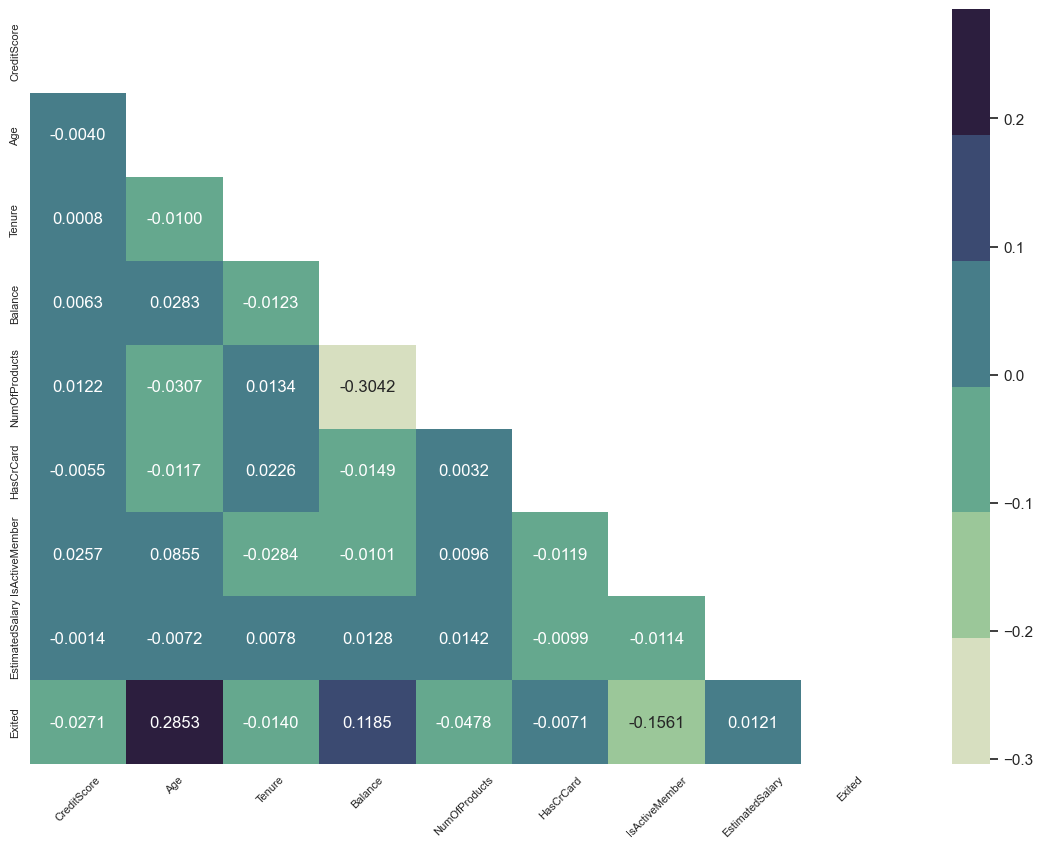

In [11]:
f, ax = plt.subplots(figsize=(14, 10))
sns.set_theme(style='darkgrid')
sns.heatmap(churn.corr(), annot=True, cmap=sns.cubehelix_palette(start=.5, rot=-.75),
            fmt= '.4f', mask= np.triu(churn.corr()), ax=ax)
plt.xticks(rotation=45)
plt.show()

Correlation matrix shows that noticeable correlation coefficient with the endogenous variable has Age(0.28), IsActiveMember(-0.16) and Balance(0.11). What is interesting there occurs negative correlation between bank account balance and number of products used by customer. It can result of fact that people with low savings more often take a loan.

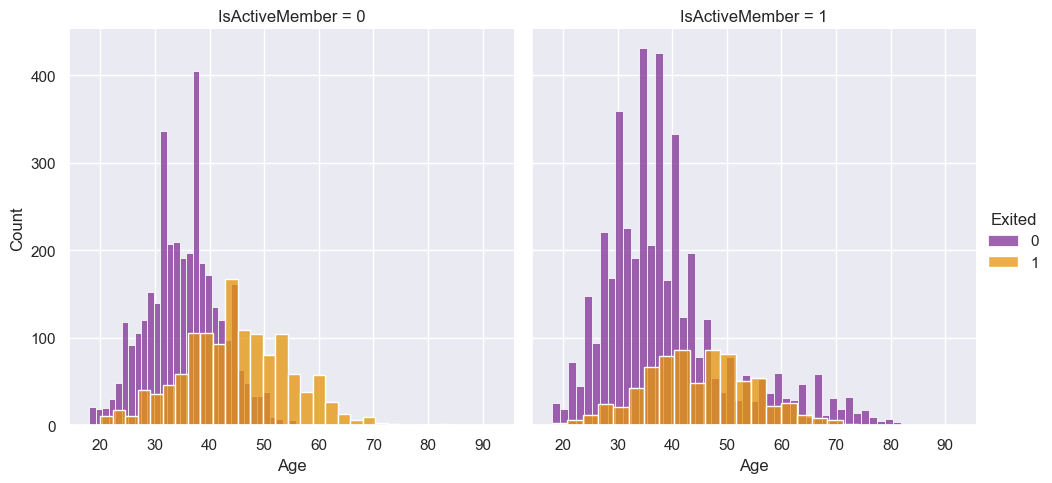

In [12]:
g = sns.FacetGrid(churn, col='IsActiveMember', hue='Exited', palette='CMRmap', size=5)
g.map(sns.histplot, 'Age')
g.add_legend()

Here distinction (by IsactiveMember) into separate charts highlights difference in distribution between Exited classes in respect of Age. 

<AxesSubplot:xlabel='CreditScore', ylabel='Count'>

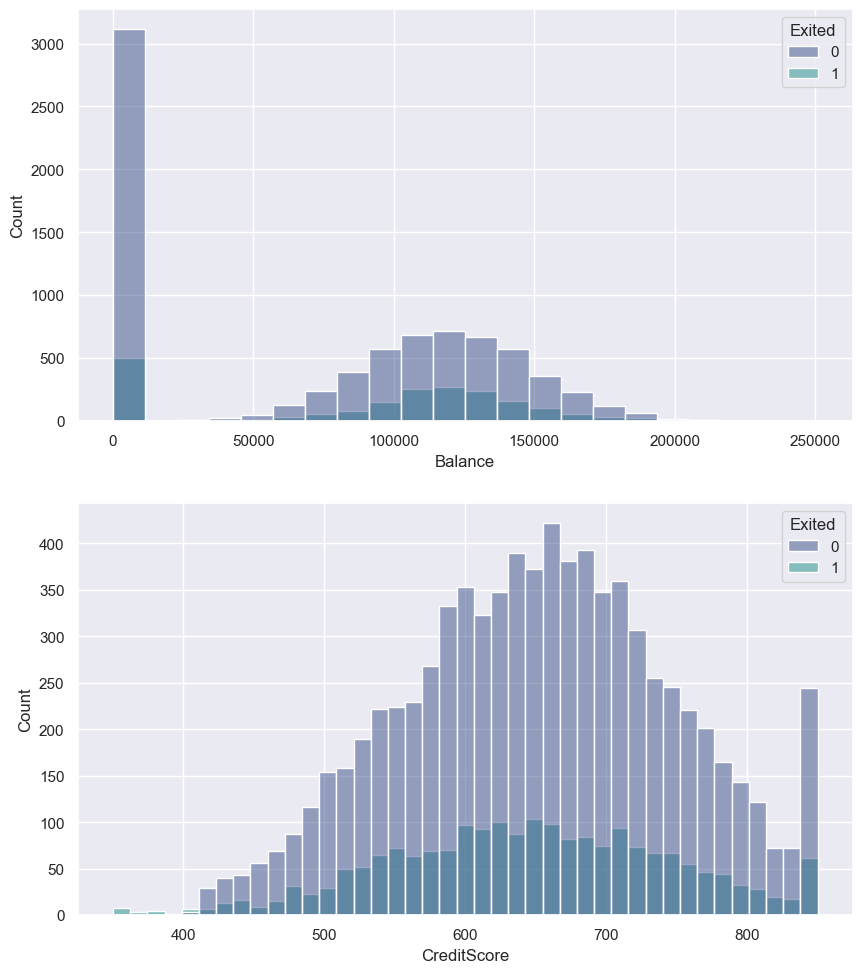

In [13]:
f, ax = plt.subplots(2, figsize=(10,12))

sns.set_palette('viridis', n_colors=3)
sns.histplot(ax=ax[0], x='Balance', hue='Exited', data=churn)
sns.histplot(ax=ax[1], x='CreditScore', hue='Exited', data=churn)

Histograms above show that class ratio is similar across the width of x-axis.

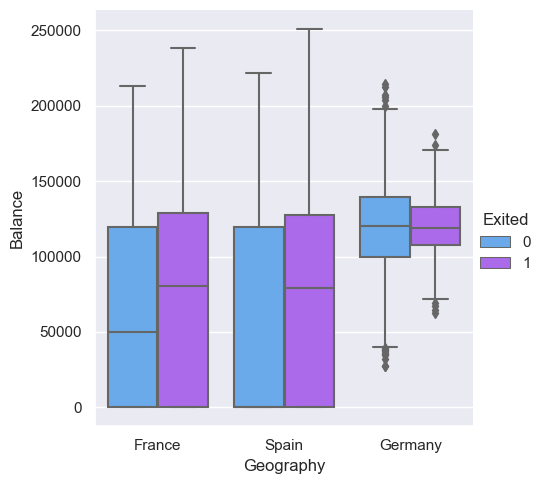

In [14]:
sns.catplot(x='Geography', y='Balance', hue='Exited', kind='box', data=churn, palette='cool')

In [15]:
churn[(churn['Geography'] == 'Spain') & (churn['Exited'] == 0)].Balance.quantile([0.5])

0.5    0.0
Name: Balance, dtype: float64

In boxplot with a distinction by country occurs very large disproportion in median between Exited class in Spain. More then half of Spaniards who exited had balance equal 0. Also Can be seen that in contrast to French and Spaniards, Germans generally have more savings.

<AxesSubplot:ylabel='Age'>

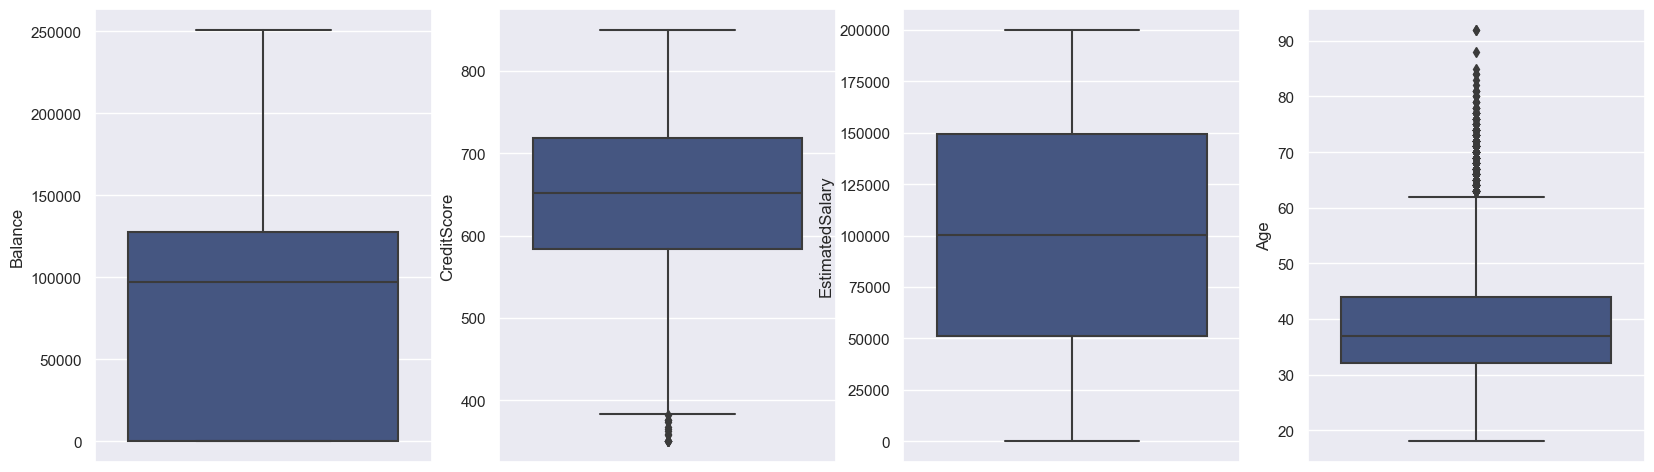

In [16]:
f, ax = plt.subplots(1, 4,figsize=(20,6))

sns.boxplot(ax=ax[0], data=churn, y='Balance')
sns.boxplot(ax=ax[1], data=churn, y='CreditScore')
sns.boxplot(ax=ax[2], data=churn, y='EstimatedSalary')
sns.boxplot(ax=ax[3], data=churn, y='Age')

Boxplot marks there are outliers in CreditScore and Age features. CreditScore outliers aren't significant, are close to cut-off point and follow from nature of determining creditworthiness. It doesn't look like it is any error or mistake. The same is the case with Age. In view of these circumstances outliers elimination is unnecessary.

## Data preparation

### Log transformation of Age Feature 
Amidst continuous variables only Age is strongly skewed, thus this feature needs to be transformed. 

In [17]:
churn['LogAge'] = np.log(churn['Age'])

<AxesSubplot:xlabel='LogAge', ylabel='Count'>

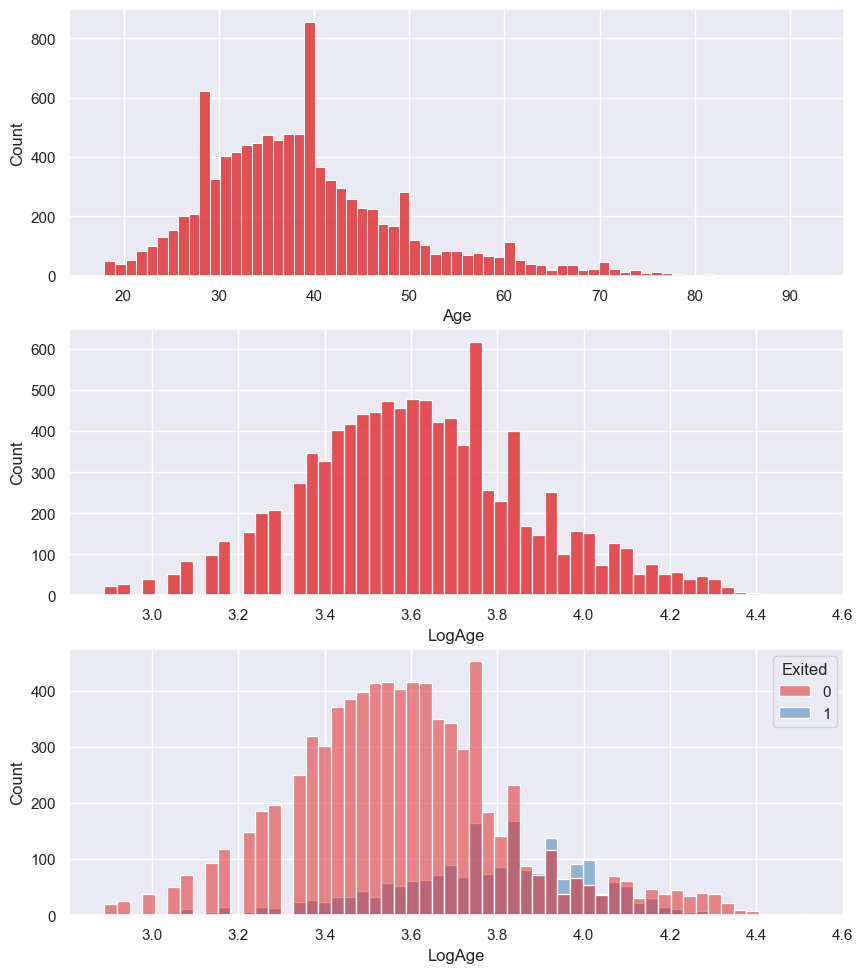

In [18]:
f, ax = plt.subplots(3, figsize=(10,12))

sns.set_palette('Set1', n_colors=3)
sns.histplot(ax=ax[0], x='Age', data=churn)
sns.histplot(ax=ax[1], x='LogAge', data=churn)
sns.histplot(ax=ax[2], x='LogAge', hue='Exited', data=churn)

In [19]:
skew = churn.skew()
skew = pd.DataFrame(skew, columns=['Variable skewness'])
skew.loc[['Age', 'LogAge']]

,Variable skewness
Age,1.01132
LogAge,0.18202


In [20]:
churn.drop(axis=1, columns=['Age'], inplace=True)

### Categorical features to dummies
Model can calculate only on numeric variables, hence categorical data needs to be replaced with binary features.

In [21]:
churn = pd.get_dummies(churn, columns=['Geography', 'Gender'], drop_first=True)
churn.head()

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,LogAge,Geography_Germany,Geography_Spain,Gender_Male
0,619,2,0.00,1,1,1,101348.88,1,3.737670,0,0,0
1,608,1,83807.86,1,0,1,112542.58,0,3.713572,0,1,0
2,502,8,159660.80,3,1,0,113931.57,1,3.737670,0,0,0
3,699,1,0.00,2,0,0,93826.63,0,3.663562,0,0,0
4,850,2,125510.82,1,1,1,79084.10,0,3.761200,0,1,0


### Multicollinearity test
If amid two features occurs multicollinearity, elimination of one of them should be considered. Variance inflation factor examines the dependencies between variables:
<br> VIF=1 -no multicollinearity
<br> 1<VIF<10 -occurs insignificant multicollinearity
<br> VIF>10 -occurs strong multicollinearity, variable should be eleminated

In [22]:
X = add_constant(churn.drop(axis=1, columns=['Exited']))

pd.Series([variance_inflation_factor(X.values, i) 
           for i in range(X.shape[1])], 
           index=X.columns)

const                269.593391
CreditScore            1.001076
Tenure                 1.001961
Balance                1.336469
NumOfProducts          1.122294
HasCrCard              1.001583
IsActiveMember         1.007308
EstimatedSalary        1.000927
LogAge                 1.009106
Geography_Germany      1.339888
Geography_Spain        1.124678
Gender_Male            1.003166
dtype: float64

### Train-test split

In [23]:
X = churn.drop('Exited', axis=1)
y = churn['Exited'].values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=rndm)

### Features scaling
Enables dispose of discrepancies between features, so their weights are equal in modelling. Many models requires this operation for appropriate functioning. RobustScaler - range of this scaler is based on quartiles so scaling is not influenced by marginal outliers. Some of features in this project have outlying values, thus this scaling method was choosed.

In [25]:
scaler = RobustScaler()

In [26]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelling

In [27]:
result = pd.DataFrame(columns=['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F-score', 'Roc_auc_score'])

def results(name):
    result.loc[len(result.index)] = [
        name, metrics.accuracy_score(y_test, y_pred), metrics.precision_score(y_test, y_pred),
        metrics.recall_score(y_test, y_pred), metrics.f1_score(y_test, y_pred),
        metrics.roc_auc_score(y_test, y_pred)
    ]

#### Logistic reggresion

In [28]:
lr = LogisticRegression(random_state=rndm)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [29]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1593
           1       0.59      0.20      0.30       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



In [30]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))
print("f1 score: ", metrics.f1_score(y_test, y_pred))

roc_auc_score:  0.5819317005757683
f1 score:  0.2977941176470588


In [31]:
results('Logistic regression')

#### Random forrest

In [32]:
rf = RandomForestClassifier(random_state=rndm)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [33]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.74      0.43      0.54       407

    accuracy                           0.85      2000
   macro avg       0.81      0.69      0.73      2000
weighted avg       0.84      0.85      0.84      2000



In [34]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))
print("f1 score: ", metrics.f1_score(y_test, y_pred))

roc_auc_score:  0.6936983208169649
f1 score:  0.540625


In [35]:
results('Random forrest')

#### Gaussian naive bayes

In [36]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

In [37]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1593
           1       0.59      0.32      0.42       407

    accuracy                           0.82      2000
   macro avg       0.72      0.63      0.65      2000
weighted avg       0.79      0.82      0.79      2000



In [38]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))
print("f1 score: ", metrics.f1_score(y_test, y_pred))

roc_auc_score:  0.6326850733630394
f1 score:  0.4171974522292993


In [39]:
results('Gaussian naive bayes')

#### Support vector classifier 

In [40]:
svc = SVC(random_state=rndm)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [41]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1593
           1       0.76      0.32      0.46       407

    accuracy                           0.84      2000
   macro avg       0.81      0.65      0.68      2000
weighted avg       0.83      0.84      0.82      2000



In [42]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))
print("f1 score: ", metrics.f1_score(y_test, y_pred))

roc_auc_score:  0.6492933611577679
f1 score:  0.4551724137931034


In [43]:
results('Support vector classifier')

#### K-nearest neighbors

In [44]:
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)
y_pred = kn.predict(X_test)

In [45]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1593
           1       0.60      0.35      0.44       407

    accuracy                           0.82      2000
   macro avg       0.72      0.64      0.67      2000
weighted avg       0.80      0.82      0.80      2000



In [46]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))
print("f1 score: ", metrics.f1_score(y_test, y_pred))

roc_auc_score:  0.6446292209004074
f1 score:  0.4409937888198758


In [47]:
results('K-nearest neighbors')

#### Linear discriminant analysis

In [48]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

In [49]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1593
           1       0.58      0.20      0.30       407

    accuracy                           0.81      2000
   macro avg       0.70      0.58      0.59      2000
weighted avg       0.77      0.81      0.77      2000



In [50]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))
print("f1 score: ", metrics.f1_score(y_test, y_pred))

roc_auc_score:  0.5819047090233531
f1 score:  0.2987249544626594


In [51]:
results('Linear discriminant analysis')

#### XGBoost 

In [52]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [53]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1593
           1       0.70      0.45      0.55       407

    accuracy                           0.85      2000
   macro avg       0.79      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000



In [54]:
print("roc_auc_score: ", metrics.roc_auc_score(y_test, y_pred))
print("f1 score: ", metrics.f1_score(y_test, y_pred))

roc_auc_score:  0.7027906180448554
f1 score:  0.5522388059701493


In [55]:
results('XGBoost classifier')

### Results comaprison

In [56]:
result.style.highlight_max(subset=['Accuracy', 'Precision', 'Recall', 'F-score', 'Roc_auc_score'], color='Cyan')

,Algorithm,Accuracy,Precision,Recall,F-score,Roc_auc_score
0,Logistic regression,0.809000,0.591241,0.199017,0.297794,0.581932
1,Random forrest,0.853000,0.742489,0.425061,0.540625,0.693698
2,Gaussian naive bayes,0.817000,0.592760,0.321867,0.417197,0.632685
3,Support vector classifier,0.842000,0.763006,0.324324,0.455172,0.649293
4,K-nearest neighbors,0.820000,0.599156,0.348894,0.440994,0.644629
5,Linear discriminant analysis,0.807500,0.577465,0.201474,0.298725,0.581905
6,XGBoost classifier,0.850000,0.703422,0.454545,0.552239,0.702791


Dataframe above contains important scores describing models performances. XGBoost scored highest in Recall, F-score and ROC/AUC score. Support vector in Precision and Random forrest in Acurracy. Among these indicators F1-score is choosed as the most important and informative measure for its combination of precision and recall. Also this score works well with imbalanced data. Thus, hyperparameter tuning is focused on increasing F1-score.

#### ROC/AUC comparison plots

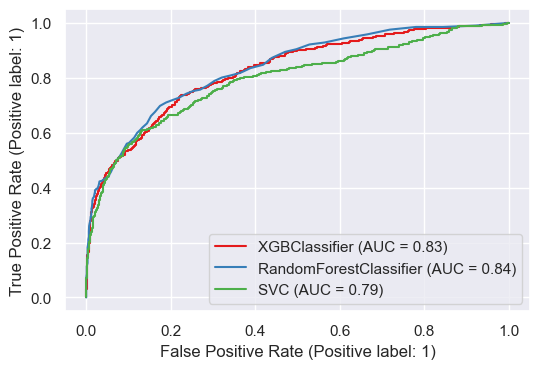

In [57]:
classifiers = [xgb, rf, svc]
ax = plt.gca()
for i in classifiers:
    metrics.plot_roc_curve(i, X_test, y_test, ax=ax)

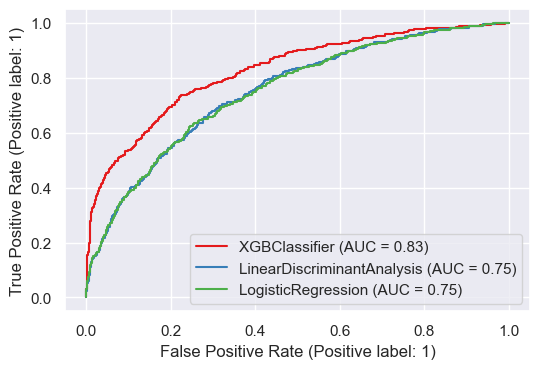

In [58]:
classifiers = [xgb, lda,lr]
ax = plt.gca()
for i in classifiers:
    metrics.plot_roc_curve(i, X_test, y_test, ax=ax)

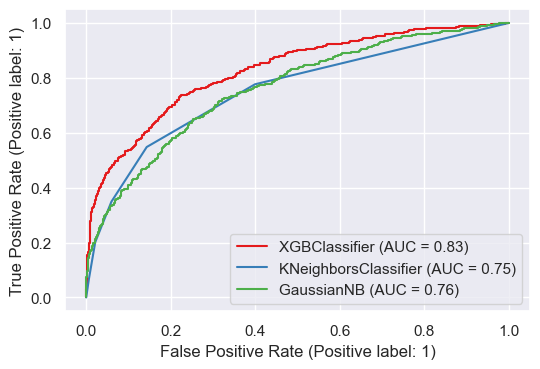

In [59]:
classifiers = [xgb, kn, nb]
ax = plt.gca()
for i in classifiers:
    metrics.plot_roc_curve(i, X_test, y_test, ax=ax)

ROC charts show there are two models (Random forrest, Support vector classifier) that achieve a similar result as XGBoost. So these three classifiers will be considered for further modelling.

### Hyperparameters tuning

Dropping rejected models from score dataframe

In [60]:
result.drop(axis=0, index=[0,2,4,5], inplace=True)
result.reset_index(inplace=True)
result.drop(axis=1, columns=['index'], inplace=True)
result

,Algorithm,Accuracy,Precision,Recall,F-score,Roc_auc_score
0,Random forrest,0.853,0.742489,0.425061,0.540625,0.693698
1,Support vector classifier,0.842,0.763006,0.324324,0.455172,0.649293
2,XGBoost classifier,0.850,0.703422,0.454545,0.552239,0.702791


In [61]:
f1 = metrics.make_scorer(metrics.f1_score, average='macro')

Scorer for parameters search (F1-score)

#### Random Forrest

In [62]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(parameters)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [63]:
rf_rnd = RandomizedSearchCV(estimator=rf, param_distributions=parameters,
                            scoring=f1, n_jobs=-1, random_state=rndm)
rf_rnd.fit(X_train, y_train)

print("The best score across all searched params: ", rf_rnd.best_score_)
print("\n The best parameters across all searched params:\n", rf_rnd.best_params_)

The best score across all searched params:  0.758317991399816

 The best parameters across all searched params:
 {'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}


In [64]:
rf_grid = RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=1, random_state=rndm)
parameters = {'n_estimators': [2000, 2200],
              'max_depth': [110, 120],
              'min_samples_split': [8, 10, 12]
              }

gridCV = GridSearchCV(rf_grid, parameters, cv=5, n_jobs=-1, scoring=f1)
gridCV.fit(X_train, y_train)
print('Best parameters:' + str(gridCV.best_params_))
print('Best accuracy in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'max_depth': 110, 'min_samples_split': 10, 'n_estimators': 2000}
Best accuracy in cross-validation:0.758317991399816


In [65]:
rf_t = RandomForestClassifier(max_depth=110, min_samples_leaf=1, min_samples_split=10,
                            n_estimators=2000, bootstrap=False, max_features='sqrt',
                            random_state=rndm)
rf_t.fit(X_train, y_train)
y_pred = rf_t.predict(X_test)

In [66]:
results('Random forrest tuned')

#### XGBoost

In [67]:
eta = [float(x) for x in np.linspace(start=0.01, stop=0.39, num=10)]
gamma= [0, 0.1, 0.2]
max_depth = [4, 6, 8]
min_child_weight = [float(x) for x in np.linspace(start=0, stop=4, num=9)]
subsample = [float(x) for x in np.linspace(start=0.6, stop=1.0, num=5)]

parameters = {'eta': eta,
              'gamma': gamma,
              'max_depth': max_depth,
              'min_child_weight': min_child_weight,
              'subsample': subsample
             }

print(parameters)

{'eta': [0.01, 0.052222222222222225, 0.09444444444444444, 0.1366666666666667, 0.1788888888888889, 0.22111111111111112, 0.26333333333333336, 0.3055555555555556, 0.3477777777777778, 0.39], 'gamma': [0, 0.1, 0.2], 'max_depth': [4, 6, 8], 'min_child_weight': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0], 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]}


In [68]:
xgb_rnd = RandomizedSearchCV(estimator=xgb, param_distributions=parameters,
                             scoring=f1, n_jobs=-1, random_state=rndm)
xgb_rnd.fit(X_train, y_train)

print("The best score across all searched params: ", xgb_rnd.best_score_)
print("\n The best parameters across all searched params:\n", xgb_rnd.best_params_)

The best score across all searched params:  0.7537314182146015

 The best parameters across all searched params:
 {'subsample': 0.6, 'min_child_weight': 2.0, 'max_depth': 4, 'gamma': 0, 'eta': 0.22111111111111112}


In [69]:
xgb_grid = XGBClassifier(subsample=0.6, eval_metric='logloss')
parameters = {'eta': [0.20,0.22,0.24],
              'gamma': [0.15,0.20,0.25],
              'max_depth': [3,4,5],
              'min_child_weight': [1.8,2.0,2.2]
             }

gridCV = GridSearchCV(xgb_grid, parameters, cv=5, n_jobs=-1, scoring=f1)
gridCV.fit(X_train, y_train)
print('Best parameters:' + str(gridCV.best_params_))
print('Best accuracy in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'eta': 0.24, 'gamma': 0.25, 'max_depth': 3, 'min_child_weight': 2.0}
Best accuracy in cross-validation:0.7615331039464174


In [70]:
xgb_grid = XGBClassifier(subsample=0.6, max_depth=3,
                         min_child_weight=2.0, eval_metric='logloss')

parameters = {'eta': [0.23,0.24,0.25],
              'gamma': [0.25,0.28,0.30]
             }

gridCV = GridSearchCV(xgb_grid, parameters, cv=5, n_jobs=-1, scoring=f1)
gridCV.fit(X_train, y_train)
print('Best parameters:' + str(gridCV.best_params_))
print('Best accuracy in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'eta': 0.23, 'gamma': 0.25}
Best accuracy in cross-validation:0.7637574561542593


In [71]:
xgb_t = XGBClassifier(subsample=0.6, max_depth=3, min_child_weight=0.09,
                      eta=0.23, gamma=0.25, eval_metric='logloss')
xgb_t.fit(X_train, y_train)
y_pred = xgb_t.predict(X_test)

In [72]:
results("XG boost tuned")
result

,Algorithm,Accuracy,Precision,Recall,F-score,Roc_auc_score
0,Random forrest,0.8530,0.742489,0.425061,0.540625,0.693698
1,Support vector classifier,0.8420,0.763006,0.324324,0.455172,0.649293
2,XGBoost classifier,0.8500,0.703422,0.454545,0.552239,0.702791
3,Random forrest tuned,0.8525,0.741379,0.422604,0.538341,0.692470
4,XG boost tuned,0.8540,0.729084,0.449631,0.556231,0.703472


#### Support vector classifier

In [73]:
kernel = ['rbf', 'poly']
C = [float(x) for x in np.logspace(-1,2,5)]
gamma = ['auto', 'scale']

In [74]:
parameters = {'kernel': kernel, 'C': C, 'gamma': gamma}
svc_rnd = RandomizedSearchCV(estimator=svc, param_distributions=parameters, 
                             n_jobs=-1, scoring=f1, random_state=rndm)
svc_rnd.fit(X_train, y_train)

print("The best score across all searched params: ", svc_rnd.best_score_)
print("\n The best parameters across all searched params:\n", svc_rnd.best_params_)

The best score across all searched params:  0.749995427590119

 The best parameters across all searched params:
 {'kernel': 'rbf', 'gamma': 'auto', 'C': 100.0}


In [75]:
svc_grid = SVC(gamma='auto', random_state=rndm)
gridCV = GridSearchCV(svc_grid, param_grid={'C':[80, 100, 130, 170, 200]},
                      scoring=f1, cv=5, n_jobs=-1)
gridCV.fit(X_train, y_train)
print('Best parameters:' + str(gridCV.best_params_))
print('Best accuracy in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'C': 170}
Best accuracy in cross-validation:0.751187056311846


In [76]:
gridCV = GridSearchCV(svc_grid, param_grid={'C':[150, 160, 170, 180]},
                      scoring=f1, cv=5, n_jobs=-1)
gridCV.fit(X_train, y_train)
print('Best parameters:' + str(gridCV.best_params_))
print('Best accuracy in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'C': 170}
Best accuracy in cross-validation:0.751187056311846


In [77]:
gridCV = GridSearchCV(svc_grid, param_grid={'C':[165, 170, 175]},
                      scoring=f1, cv=5, n_jobs=-1)
gridCV.fit(X_train, y_train)
print('Best parameters:' + str(gridCV.best_params_))
print('Best accuracy in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'C': 170}
Best accuracy in cross-validation:0.751187056311846


In [78]:
svc_t = SVC(gamma='auto', C=170, random_state=rndm)
svc_t.fit(X_train, y_train)
y_pred = svc_t.predict(X_test)

In [79]:
results('Support vector tuned')

## Model evaluation 

Basic vs tuned classifiers results 

In [80]:
result.style.background_gradient(subset=['F-score'], cmap='RdPu', high=0.1).highlight_max(subset=['Accuracy', 'Precision', 'Recall', 'F-score', 'Roc_auc_score'], color='Grey')

,Algorithm,Accuracy,Precision,Recall,F-score,Roc_auc_score
0,Random forrest,0.853000,0.742489,0.425061,0.540625,0.693698
1,Support vector classifier,0.842000,0.763006,0.324324,0.455172,0.649293
2,XGBoost classifier,0.850000,0.703422,0.454545,0.552239,0.702791
3,Random forrest tuned,0.852500,0.741379,0.422604,0.538341,0.692470
4,XG boost tuned,0.854000,0.729084,0.449631,0.556231,0.703472
5,Support vector tuned,0.846000,0.710638,0.410319,0.520249,0.683816


Hyperparameters tuning improved XGboost performance and this model remains the best, a will be the final model for this project.

In [81]:
final_model = XGBClassifier(subsample=0.6, max_depth=3, min_child_weight=0.09,
                      eta=0.23, gamma=0.25, eval_metric='logloss')
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)

In [82]:
tn, fp, fn, tp = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()

conf = pd.DataFrame(columns=['Positive', 'Negative'], index=['Positive', 'Negative'], data=[[tp, fn],[fp,tn]])
conf

,Positive,Negative
Positive,183,224
Negative,68,1525


Algorithm recognized in test observations group almost 3/4 customers who have closed bank account.

In [83]:
result[result['Algorithm'] == 'XG boost tuned']

,Algorithm,Accuracy,Precision,Recall,F-score,Roc_auc_score
4,XG boost tuned,0.854,0.729084,0.449631,0.556231,0.703472


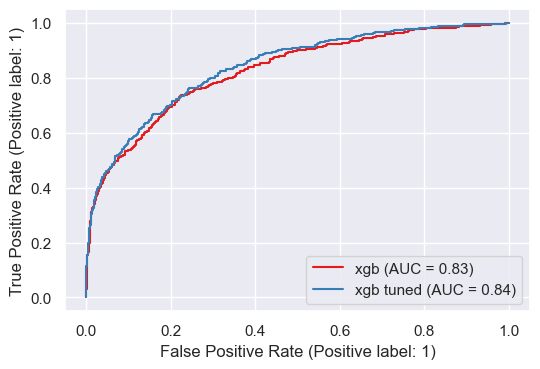

In [84]:
ax = plt.gca()
metrics.plot_roc_curve(xgb, X_test, y_test, ax=ax, name='xgb')
metrics.plot_roc_curve(final_model, X_test, y_test, ax=ax, name='xgb tuned')

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

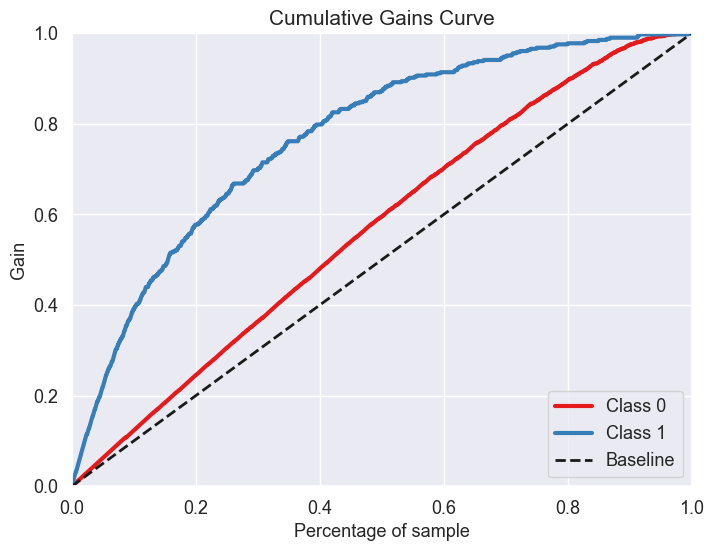

In [85]:
skplt.metrics.plot_cumulative_gain(
    y_test, y_proba, figsize=(8, 6), title_fontsize=15, text_fontsize=13)

Gains curve shows that expectedly in 40% of given bank client cases (future sample), model would find about 80% clients which would resignate.

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

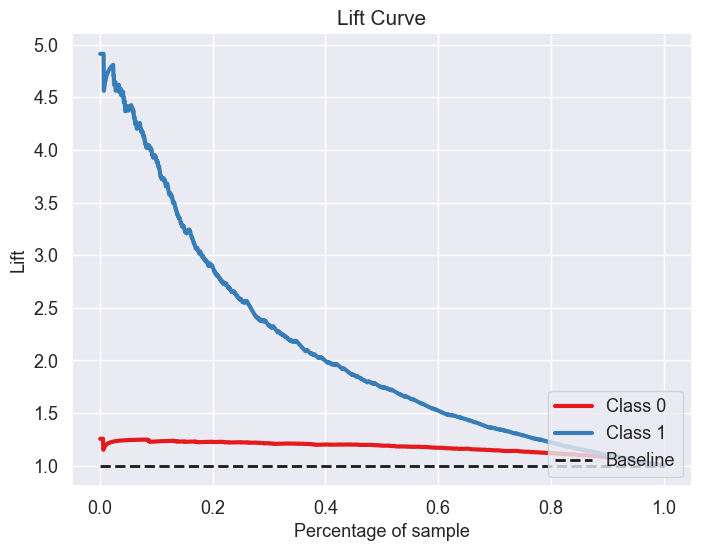

In [86]:
skplt.metrics.plot_lift_curve(
    y_test, y_proba, figsize=(8, 6), title_fontsize=15, text_fontsize=13)

Lift curve shows that model would identify 4 times more resignating clients in 10% sample of new cases population. 

These two charts can help business to weight potential gains and cost of sending an offer to certain percentage of clients. 